------------------------------
Análisis (XAI)
------------------------------
Predicción final f(x): 2.8600
Valor esperado E[f(x)]: 1.3441
Diferencia a explicar: 1.5159

Contribuciones por Característica (Vector Phi):
 -> Ingresos              :   0.7963 (Aumenta Riesgo)
 -> Historial Empleo      :   0.2941 (Aumenta Riesgo)
 -> Comportamiento Digital:   0.2557 (Aumenta Riesgo)
 -> Pagos Servicios       :   0.1602 (Aumenta Riesgo)

Suma de Phi_i: 1.5063
Cumple Axioma Eficiencia: True
------------------------------


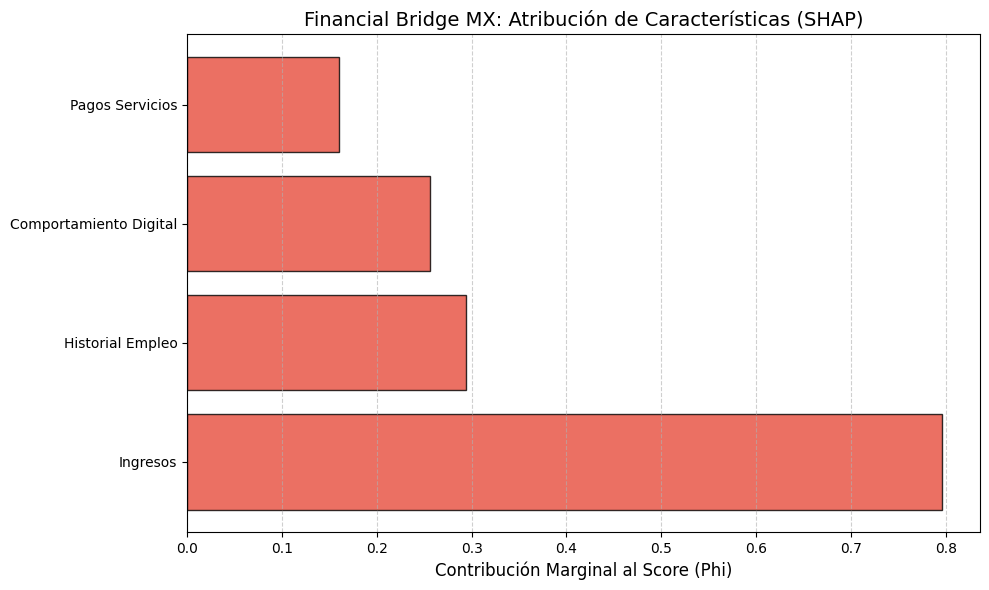

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class FinancialBridgeXAI:
    def __init__(self, model, reference_data):
        self.model = model
        self.reference_data = reference_data

    def get_shapley_contributions(self, x, n_samples=500):
        d = len(x)
        contributions = np.zeros(d)

        base_value = np.mean(self.model.predict(self.reference_data))

        for _ in range(n_samples):
            perm = np.random.permutation(d)
            x_plus = self.reference_data[np.random.randint(0, len(self.reference_data))].copy()
            x_minus = x_plus.copy()

            for j in range(d):
                idx = perm[j]
                x_plus[idx] = x[idx]
                contributions[idx] += (self.model.predict([x_plus])[0] - self.model.predict([x_minus])[0])
                x_minus[idx] = x[idx]

        phi = contributions / n_samples
        prediction = self.model.predict([x])[0]

        return phi, base_value, prediction

feature_names = ["Ingresos", "Historial Empleo", "Comportamiento Digital", "Pagos Servicios"]
x_solicitante = np.array([4.5, 3.0, 1.2, 4.0])
data_referencia = np.random.rand(50, 4) * 5

class BlackBoxModel:
    def predict(self, X):
        X = np.array(X)
        if X.ndim == 1: X = X.reshape(1, -1)
        return 0.4 * X[:, 0] + 0.3 * X[:, 1] - 0.2 * X[:, 2] + 0.1 * X[:, 3]

model = BlackBoxModel()
xai = FinancialBridgeXAI(model, data_referencia)
phi, e_f_x, pred = xai.get_shapley_contributions(x_solicitante)

print("-" * 30)
print("Análisis (XAI)")
print("-" * 30)
print(f"Predicción final f(x): {pred:.4f}")
print(f"Valor esperado E[f(x)]: {e_f_x:.4f}")
print(f"Diferencia a explicar: {pred - e_f_x:.4f}")
print("\nContribuciones por Característica (Vector Phi):")

for name, val in zip(feature_names, phi):
    impacto = "Aumenta Riesgo" if val > 0 else "Reduce Riesgo"
    print(f" -> {name:22}: {val:>8.4f} ({impacto})")

print(f"\nSuma de Phi_i: {np.sum(phi):.4f}")
print(f"Cumple Axioma Eficiencia: {np.isclose(np.sum(phi), pred - e_f_x, atol=0.01)}")
print("-" * 30)

plt.figure(figsize=(10, 6))
colores = ['#2ecc71' if p < 0 else '#e74c3c' for p in phi] # Rojo aumenta riesgo, verde lo baja
plt.barh(feature_names, phi, color=colores, edgecolor='black', alpha=0.8)
plt.axvline(0, color='black', linewidth=1.2)
plt.title("Financial Bridge MX: Atribución de Características (SHAP)", fontsize=14)
plt.xlabel("Contribución Marginal al Score (Phi)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

FINANCIAL BRIDGE MX - M2 EXPERIMENTS

ANALISIS BASE:
Prediccion: 2.8600
Contribuciones: [0.86001843 0.18678187 0.2538995  0.17183944]


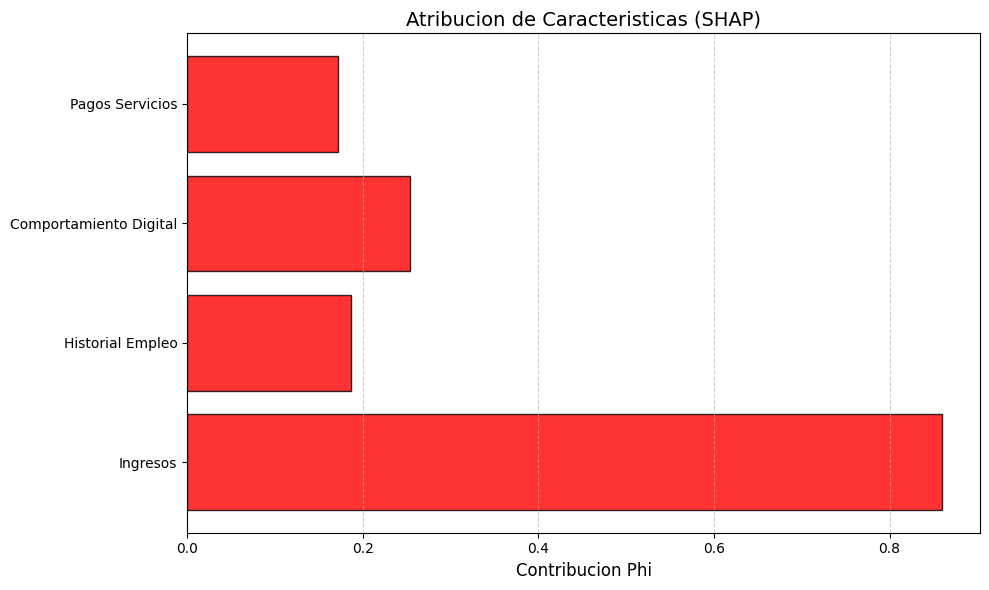

# EXPERIMENTOS M2
EXPERIMENTO 1: ESTABILIDAD BAJO PERTURBACIONES

Resultados de Estabilidad:
Ingresos              : mu(Phi) =  0.8800, sigma(Phi) =  0.1035
Historial Empleo      : mu(Phi) =  0.1817, sigma(Phi) =  0.0564
Comportamiento Digital: mu(Phi) =  0.2741, sigma(Phi) =  0.0326
Pagos Servicios       : mu(Phi) =  0.1520, sigma(Phi) =  0.0258

Stability Score: 85.33%
Trials con |Delta Phi| < 0.05: 10.0%


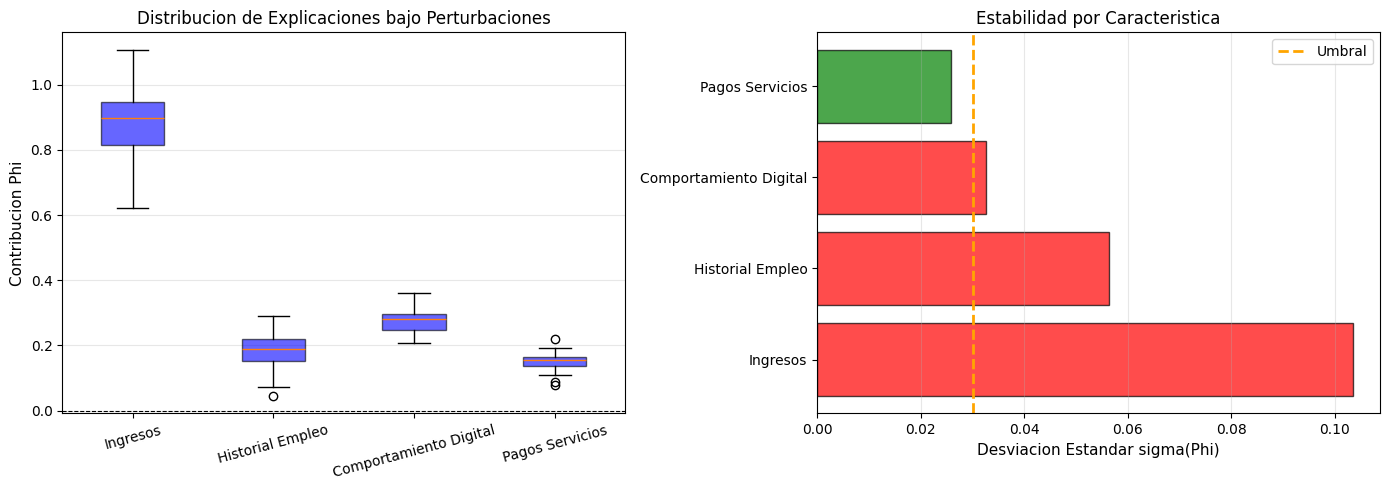

EXPERIMENTO 2: COMPARACION SHAP vs LIME

Resultados:
SHAP: Tiempo = 0.004665s, Consistency = 1.00
LIME: Tiempo = 0.001961s, Consistency = 1.00
Mejora: -0.2%


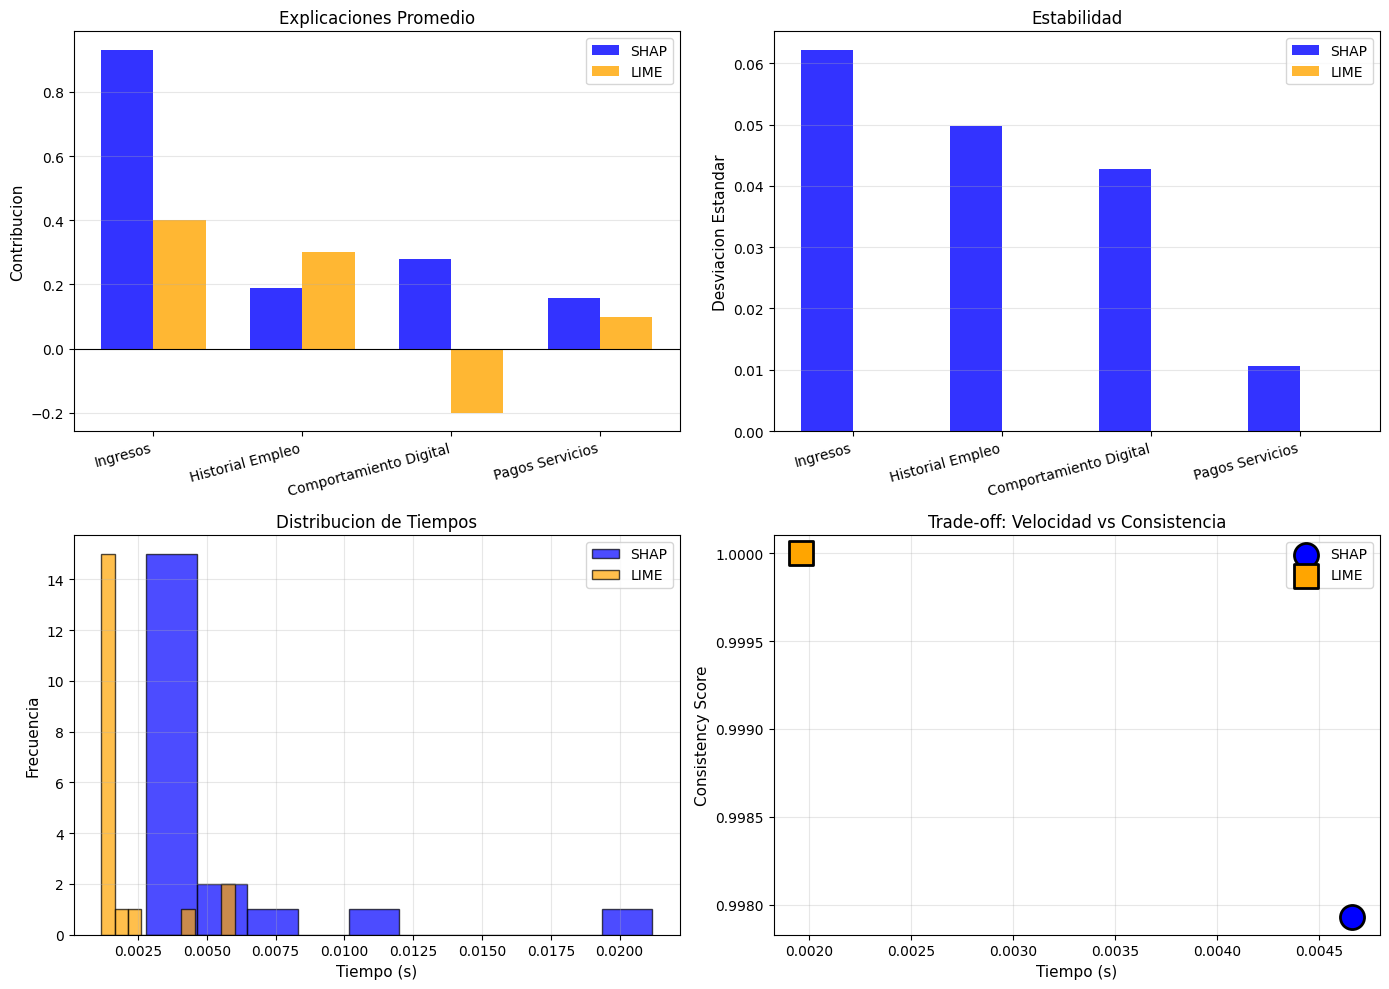

EXPERIMENTO 3: IMPACTO DE CORRELACIONES

Varianza por escenario:
Ingresos               Indep: 0.0034, Correl: 0.0017 (-51.9%)
Historial Empleo       Indep: 0.0018, Correl: 0.0006 (-67.6%)
Comportamiento Digital Indep: 0.0008, Correl: 0.0008 (+0.2%)
Pagos Servicios        Indep: 0.0002, Correl: 0.0002 (+18.1%)

Incremento promedio: -47.4%


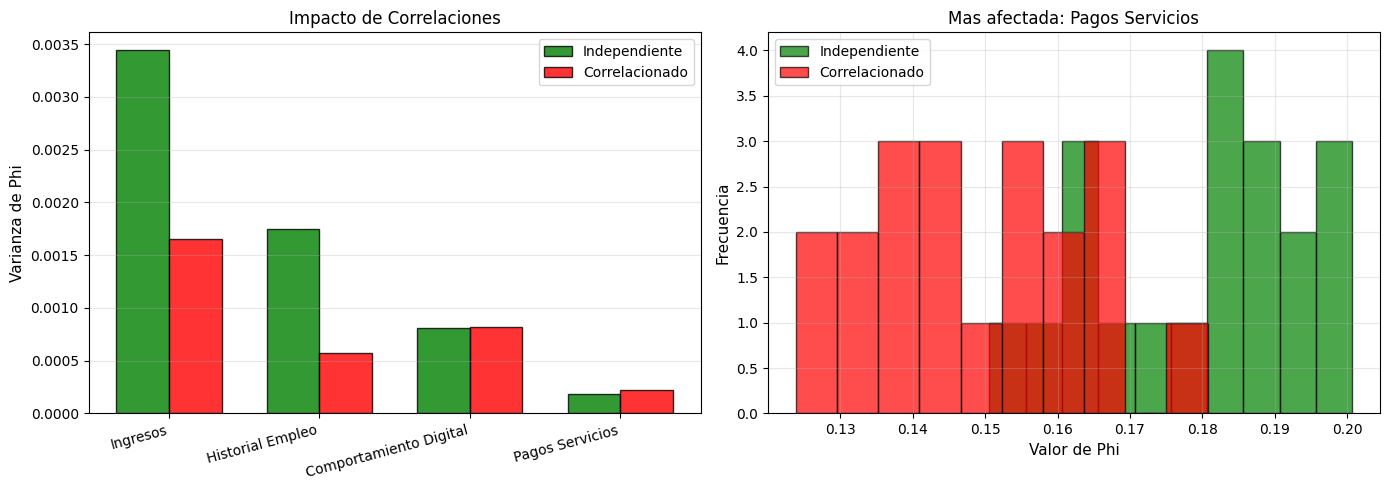

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


class FinancialBridgeXAI:
    def __init__(self, model, reference_data):
        self.model = model
        self.reference_data = reference_data

    def get_shapley_contributions(self, x, n_samples=200):
        d = len(x)
        contributions = np.zeros(d)
        base_value = np.mean(self.model.predict(self.reference_data))

        for _ in range(n_samples):
            perm = np.random.permutation(d)
            x_plus = self.reference_data[np.random.randint(0, len(self.reference_data))].copy()
            x_minus = x_plus.copy()

            for j in range(d):
                idx = perm[j]
                x_plus[idx] = x[idx]
                contributions[idx] += (self.model.predict([x_plus])[0] - self.model.predict([x_minus])[0])
                x_minus[idx] = x[idx]

        phi = contributions / n_samples
        prediction = self.model.predict([x])[0]
        return phi, base_value, prediction


class BlackBoxModel:
    def __init__(self, lambda_reg=0.01):
        self.lambda_reg = lambda_reg
        self.weights = np.array([0.4, 0.3, -0.2, 0.1])

    def predict(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return X @ self.weights


class SimpleLIME:
    def __init__(self, model, reference_data):
        self.model = model
        self.reference_data = reference_data

    def get_lime_contributions(self, x, n_samples=200):
        d = len(x)
        samples = []
        predictions = []

        for _ in range(n_samples):
            perturbation = np.random.normal(0, 0.3, d)
            sample = x + perturbation
            samples.append(sample)
            predictions.append(self.model.predict([sample])[0])

        samples = np.array(samples)
        predictions = np.array(predictions)

        local_model = Ridge(alpha=0.01)
        local_model.fit(samples, predictions)

        return local_model.coef_, local_model.intercept_, self.model.predict([x])[0]




def experiment_perturbation_stability(xai_system, x_original, feature_names, n_trials=50):
    print("EXPERIMENTO 1: ESTABILIDAD BAJO PERTURBACIONES")

    d = len(x_original)
    all_phis = []

    for trial in range(n_trials):
        noise = np.random.normal(0, 0.05 * np.abs(x_original), d)
        x_perturbed = x_original + noise
        phi, _, _ = xai_system.get_shapley_contributions(x_perturbed, n_samples=100)
        all_phis.append(phi)

    all_phis = np.array(all_phis)
    mean_phi = np.mean(all_phis, axis=0)
    std_phi = np.std(all_phis, axis=0)

    print("\nResultados de Estabilidad:")
    for i, name in enumerate(feature_names):
        print(f"{name:22}: mu(Phi) = {mean_phi[i]:>7.4f}, sigma(Phi) = {std_phi[i]:>7.4f}")

    stability_score = 1 - np.mean(std_phi) / (np.mean(np.abs(mean_phi)) + 1e-6)
    print(f"\nStability Score: {stability_score:.2%}")
    print(f"Trials con |Delta Phi| < 0.05: {np.mean(np.max(np.abs(all_phis - mean_phi), axis=1) < 0.05):.1%}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    bp = ax1.boxplot([all_phis[:, i] for i in range(d)], labels=feature_names, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('blue')
        patch.set_alpha(0.6)
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax1.set_ylabel('Contribucion Phi', fontsize=11)
    ax1.set_title('Distribucion de Explicaciones bajo Perturbaciones', fontsize=12)
    ax1.tick_params(axis='x', rotation=15)
    ax1.grid(axis='y', alpha=0.3)

    colors = ['red' if s > 0.03 else 'green' for s in std_phi]
    ax2.barh(feature_names, std_phi, color=colors, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Desviacion Estandar sigma(Phi)', fontsize=11)
    ax2.set_title('Estabilidad por Caracteristica', fontsize=12)
    ax2.axvline(0.03, color='orange', linewidth=2, linestyle='--', label='Umbral')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('exp1_perturbation_stability.png', dpi=150, bbox_inches='tight')
    plt.show()

    return mean_phi, std_phi, stability_score


def experiment_shap_vs_lime(model, reference_data, x_test, feature_names, n_trials=20):
    print("EXPERIMENTO 2: COMPARACION SHAP vs LIME")

    xai_shap = FinancialBridgeXAI(model, reference_data)
    xai_lime = SimpleLIME(model, reference_data)

    shap_explanations = []
    lime_explanations = []
    shap_times = []
    lime_times = []

    for trial in range(n_trials):
        start = time.time()
        phi_shap, _, _ = xai_shap.get_shapley_contributions(x_test, n_samples=100)
        shap_times.append(time.time() - start)
        shap_explanations.append(phi_shap)

        start = time.time()
        phi_lime, _, _ = xai_lime.get_lime_contributions(x_test, n_samples=100)
        lime_times.append(time.time() - start)
        lime_explanations.append(phi_lime)

    shap_explanations = np.array(shap_explanations)
    lime_explanations = np.array(lime_explanations)

    shap_variance = np.mean(np.var(shap_explanations, axis=0))
    lime_variance = np.mean(np.var(lime_explanations, axis=0))

    shap_consistency = 1 - shap_variance
    lime_consistency = 1 - lime_variance

    print("\nResultados:")
    print(f"SHAP: Tiempo = {np.mean(shap_times):.6f}s, Consistency = {shap_consistency:.2f}")
    print(f"LIME: Tiempo = {np.mean(lime_times):.6f}s, Consistency = {lime_consistency:.2f}")
    print(f"Mejora: {((shap_consistency - lime_consistency) / lime_consistency * 100):.1f}%")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    x_pos = np.arange(len(feature_names))
    width = 0.35
    axes[0,0].bar(x_pos - width/2, np.mean(shap_explanations, axis=0), width, label='SHAP', color='blue', alpha=0.8)
    axes[0,0].bar(x_pos + width/2, np.mean(lime_explanations, axis=0), width, label='LIME', color='orange', alpha=0.8)
    axes[0,0].set_ylabel('Contribucion', fontsize=11)
    axes[0,0].set_title('Explicaciones Promedio', fontsize=12)
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(feature_names, rotation=15, ha='right')
    axes[0,0].legend()
    axes[0,0].axhline(0, color='black', linewidth=0.8)
    axes[0,0].grid(axis='y', alpha=0.3)

    axes[0,1].bar(x_pos - width/2, np.std(shap_explanations, axis=0), width, label='SHAP', color='blue', alpha=0.8)
    axes[0,1].bar(x_pos + width/2, np.std(lime_explanations, axis=0), width, label='LIME', color='orange', alpha=0.8)
    axes[0,1].set_ylabel('Desviacion Estandar', fontsize=11)
    axes[0,1].set_title('Estabilidad', fontsize=12)
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(feature_names, rotation=15, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)

    axes[1,0].hist(shap_times, bins=10, alpha=0.7, label='SHAP', color='blue', edgecolor='black')
    axes[1,0].hist(lime_times, bins=10, alpha=0.7, label='LIME', color='orange', edgecolor='black')
    axes[1,0].set_xlabel('Tiempo (s)', fontsize=11)
    axes[1,0].set_ylabel('Frecuencia', fontsize=11)
    axes[1,0].set_title('Distribucion de Tiempos', fontsize=12)
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)

    axes[1,1].scatter(np.mean(shap_times), shap_consistency, s=300, c='blue', label='SHAP', marker='o', zorder=3, edgecolor='black', linewidth=2)
    axes[1,1].scatter(np.mean(lime_times), lime_consistency, s=300, c='orange', label='LIME', marker='s', zorder=3, edgecolor='black', linewidth=2)
    axes[1,1].set_xlabel('Tiempo (s)', fontsize=11)
    axes[1,1].set_ylabel('Consistency Score', fontsize=11)
    axes[1,1].set_title('Trade-off: Velocidad vs Consistencia', fontsize=12)
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('exp2_shap_vs_lime.png', dpi=150, bbox_inches='tight')
    plt.show()

    return shap_consistency, lime_consistency


def experiment_correlation_impact(model, x_test, feature_names, n_trials=20):
    print("EXPERIMENTO 3: IMPACTO DE CORRELACIONES")

    ref_data_independent = np.random.rand(50, 4) * 5
    xai_independent = FinancialBridgeXAI(model, ref_data_independent)

    ref_data_correlated = np.random.rand(50, 4) * 5
    ref_data_correlated[:, 1] = 0.7 * ref_data_correlated[:, 0] + np.random.randn(50) * 0.5
    xai_correlated = FinancialBridgeXAI(model, ref_data_correlated)

    phis_independent = []
    phis_correlated = []

    for _ in range(n_trials):
        phi_ind, _, _ = xai_independent.get_shapley_contributions(x_test, n_samples=100)
        phi_corr, _, _ = xai_correlated.get_shapley_contributions(x_test, n_samples=100)
        phis_independent.append(phi_ind)
        phis_correlated.append(phi_corr)

    phis_independent = np.array(phis_independent)
    phis_correlated = np.array(phis_correlated)

    var_independent = np.var(phis_independent, axis=0)
    var_correlated = np.var(phis_correlated, axis=0)

    print("\nVarianza por escenario:")
    for i, name in enumerate(feature_names):
        increment = ((var_correlated[i] - var_independent[i]) / var_independent[i]) * 100
        print(f"{name:<22} Indep: {var_independent[i]:.4f}, Correl: {var_correlated[i]:.4f} ({increment:+.1f}%)")

    avg_increment = ((np.mean(var_correlated) - np.mean(var_independent)) / np.mean(var_independent)) * 100
    print(f"\nIncremento promedio: {avg_increment:+.1f}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    x_pos = np.arange(len(feature_names))
    width = 0.35
    ax1.bar(x_pos - width/2, var_independent, width, label='Independiente', color='green', alpha=0.8, edgecolor='black')
    ax1.bar(x_pos + width/2, var_correlated, width, label='Correlacionado', color='red', alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Varianza de Phi', fontsize=11)
    ax1.set_title('Impacto de Correlaciones', fontsize=12)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(feature_names, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    most_affected = np.argmax(var_correlated - var_independent)
    ax2.hist(phis_independent[:, most_affected], bins=10, alpha=0.7, label='Independiente', color='green', edgecolor='black')
    ax2.hist(phis_correlated[:, most_affected], bins=10, alpha=0.7, label='Correlacionado', color='red', edgecolor='black')
    ax2.set_xlabel('Valor de Phi', fontsize=11)
    ax2.set_ylabel('Frecuencia', fontsize=11)
    ax2.set_title(f'Mas afectada: {feature_names[most_affected]}', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('exp3_correlation_impact.png', dpi=150, bbox_inches='tight')
    plt.show()

    return var_independent, var_correlated



def main():
    print("FINANCIAL BRIDGE MX - M2 EXPERIMENTS")

    feature_names = ["Ingresos", "Historial Empleo", "Comportamiento Digital", "Pagos Servicios"]
    x_solicitante = np.array([4.5, 3.0, 1.2, 4.0])
    data_referencia = np.random.rand(50, 4) * 5

    model = BlackBoxModel(lambda_reg=0.01)
    xai = FinancialBridgeXAI(model, data_referencia)

    print("\nANALISIS BASE:")
    phi, e_f_x, pred = xai.get_shapley_contributions(x_solicitante)
    print(f"Prediccion: {pred:.4f}")
    print(f"Contribuciones:", phi)

    plt.figure(figsize=(10, 6))
    colores = ['green' if p < 0 else 'red' for p in phi]
    plt.barh(feature_names, phi, color=colores, edgecolor='black', alpha=0.8)
    plt.axvline(0, color='black', linewidth=1.2)
    plt.title("Atribucion de Caracteristicas (SHAP)", fontsize=14)
    plt.xlabel("Contribucion Phi", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('original_shap.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("# EXPERIMENTOS M2")

    mean_phi, std_phi, stability = experiment_perturbation_stability(xai, x_solicitante, feature_names, n_trials=50)
    shap_cons, lime_cons = experiment_shap_vs_lime(model, data_referencia, x_solicitante, feature_names, n_trials=20)
    var_ind, var_corr = experiment_correlation_impact(model, x_solicitante, feature_names, n_trials=20)




if __name__ == "__main__":
    main()